In [1]:
# Using BERT trained on pubmed text for literature update classificaiton.

In [5]:
import numpy as np
np.random.seed(541)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle 
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix
!pip install -q -U tf-models-official
from official.nlp import optimization  # to create AdamW optmizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
## Load BERT model and preprocessing model
# https://www.tensorflow.org/tutorials/text/classify_text_with_bert#loading_models_from_tensorflow_hub
!pip install -q -U tensorflow_text

import tensorflow_hub as hub
import tensorflow_text as text

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1'
tfhub_handle_encoder = 'https://tfhub.dev/google/experts/bert/pubmed/2'

drive.mount('/content/gdrive')

## read in data ----
df = pd.read_csv('/content/gdrive/My Drive/literature_update/Data/Biomch-L_papers+WEARABLES.csv', encoding='UTF-8-SIG')
df.columns = ['X','topic_split', 'topic', 'authors','title','journal','year','vol_issue','doi','abstract']

# keep just topics where there are at least 900 entries:
df = df.groupby('topic').filter(lambda x: len(x) > 444)
# remove unique topics
df.drop(df[df['topic'] == 'UNIQUETOPIC'].index, inplace=True)

# total number of topics
n_topics = len(df.groupby('topic').size())

## encode topic labels ----
le = LabelEncoder()
le.fit(list(df['topic'].to_numpy()))
df['topic_n'] = le.transform(list(df['topic'])).astype(np.int32)
np.save('/content/gdrive/My Drive/literature_update/Data/BERT_label_encoder.npy', le.classes_)

num_topics = max(df['topic_n'])+1

df['title'] = df['title'].replace(np.nan, '', regex = True)
df['abstract'] = df['abstract'].replace(np.nan, '', regex = True)
df.drop(['X', 'topic_split', 'authors', 'journal', 'year', 'vol_issue', 'doi'], axis=1, inplace=True)
df.head()
df.sort_index(inplace=True)
class_names = le.inverse_transform(df['topic_n'].unique())

## clean up title and abstract text ----
#set cleaning parameters
def clean(t):
    t = t.split()
    return ' '.join([(i) for (i) in t if i not in stop])

stop = list(stopwords.words('english'))
stop.append('The')
stop.append('An')
stop.append('A')
stop.append('Do')
stop.append('Is')
stop.append('In')

new_stop = ['StringElement','NlmCategory','Label','attributes','INTRODUCTION',
            'METHODS','BACKGROUND','RESULTS','CONCLUSIONS']
for item in new_stop:
    stop.append(item)

#apply cleaning to title and abstract text
df['title'] = df['title'].apply(clean)
df['abstract'] = df['abstract'].apply(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# if a topic occurs more than 1800 times, keep random sample of 1800.
keys = df.groupby('topic')['title'].nunique().index
vals = df.groupby('topic')['title'].nunique().values
for n,i in enumerate(vals):
  if i > 1000:
    vals[n] = 1000

# store topics and number of rows to keep in dict for apply()
n_keep = {keys[i]: vals[i] for i in range(len(keys))} 
# use dict of topics/rows to keep to sample from df:
df = df.groupby('topic').apply(lambda topic: topic.sample(n_keep[topic.name], random_state=541)).reset_index(drop = True)

df.groupby('topic')['title'].nunique()

topic
BONE                              1000
BOTANY                             506
CARDIOVASCULAR/CARDIOPULMONARY    1000
CELLULAR/SUBCELLULAR              1000
COMPARATIVE                       1000
DENTAL/ORAL/FACIAL                1000
ERGONOMICS                        1000
EVOLUTION/ANTHROPOLOGY            1000
GAIT/LOCOMOTION                   1000
HAND/FINGER/FOOT/TOE               659
JOINT/CARTILAGE                   1000
METHODS                           1000
MODELING                          1000
MUSCLE                             921
NEURAL                            1000
ORTHOPAEDICS/SPINE                1000
ORTHOPAEDICS/SURGERY              1000
POSTURE/BALANCE                    563
PROSTHETICS/ORTHOTICS              677
REHABILITATION                    1000
ROBOTICS                          1000
SPORT/EXERCISE                     999
TENDON/LIGAMENT                   1000
TISSUE/BIOMATERIAL                1000
TRAUMA/IMPACT                      858
VETERINARY/AGRICULT

In [4]:
# make all classes equally represented
# n_titles = min(df.groupby('topic')['title'].nunique()) + 1
# df = df.groupby('topic').sample(n_titles, random_state=5419)  # random sample of lowest common denominator
# df.groupby('topic')['title'].nunique()

In [7]:
## Split into Test/Train ----
X = df['title'] + df['abstract'].fillna('')
y = df['topic_n']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.9,
    test_size=0.1,
    random_state=541,
    stratify=y
)

# remove orig data from memory
del df

In [8]:
# convert numpy data to tf.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds.cache().prefetch(buffer_size=AUTOTUNE)
print(class_names)
print(train_ds.element_spec)

['BONE' 'BOTANY' 'CARDIOVASCULAR/CARDIOPULMONARY' 'CELLULAR/SUBCELLULAR'
 'COMPARATIVE' 'DENTAL/ORAL/FACIAL' 'ERGONOMICS' 'EVOLUTION/ANTHROPOLOGY'
 'GAIT/LOCOMOTION' 'HAND/FINGER/FOOT/TOE' 'JOINT/CARTILAGE' 'METHODS'
 'MODELING' 'MUSCLE' 'NEURAL' 'ORTHOPAEDICS/SPINE' 'ORTHOPAEDICS/SURGERY'
 'PROSTHETICS/ORTHOTICS' 'REHABILITATION' 'SPORT/EXERCISE'
 'TENDON/LIGAMENT' 'TISSUE/BIOMATERIAL' 'TRAUMA/IMPACT'
 'VETERINARY/AGRICULTURAL' 'VISUAL/VESTIBULAR' 'POSTURE/BALANCE'
 'WEARABLE TECH' 'ROBOTICS']
(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [7]:
# # view example text and label
# for text_batch, label_batch in train_ds.take(1):
#   for i in range(5):
#     print(f'Review: {text_batch.numpy()[i]}')
#     label = label_batch.numpy()[i]
#     print(f'Label : {label} ({class_names[label]})')

In [8]:
# test an example paper title and preprocessing required for BERT
# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

# text_test = ['Sacral accelerations predict whole body kinetics and stride kinematics across running speeds']
# text_preprocessed = bert_preprocess_model(text_test)

# print(f'Keys       : {list(text_preprocessed.keys())}')
# print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
# print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
# print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
# print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

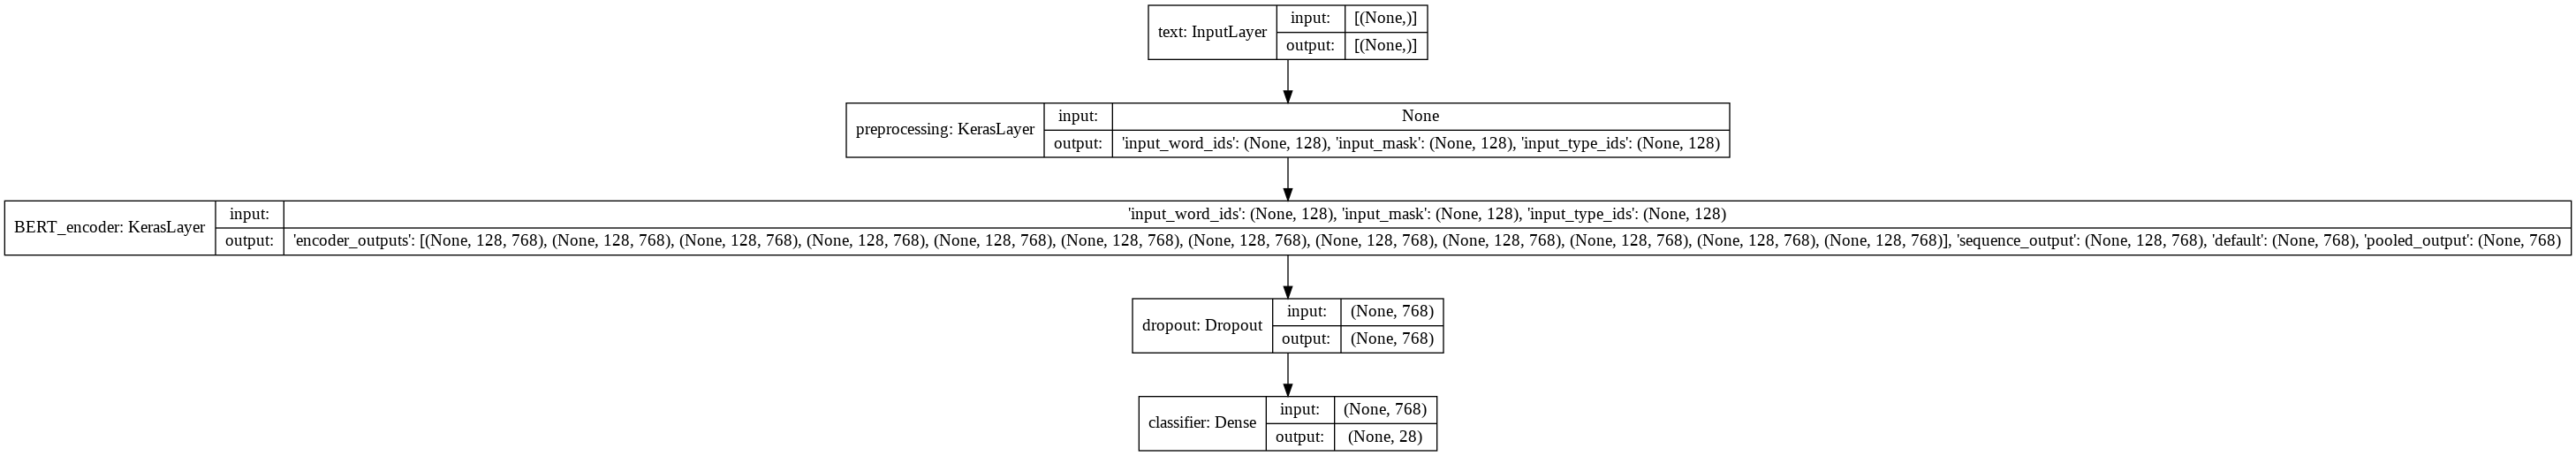

In [9]:
# Define BERT model (DOWNLOADS BERT FROM TF.HUB, so be patient...)
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(len(class_names), activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

# test run with example text from earlier
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))
tf.keras.utils.plot_model(classifier_model, show_shapes=True)

In [10]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5 # 5e-5 and 2e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [11]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/google/experts/bert/pubmed/2
Epoch 1/3
721/721 [==============================] - 711s 963ms/step - loss: 2.3200 - accuracy: 0.3657 - val_loss: 0.9982 - val_accuracy: 0.6984
Epoch 2/3
721/721 [==============================] - 693s 961ms/step - loss: 0.9403 - accuracy: 0.7205 - val_loss: 0.9417 - val_accuracy: 0.7121
Epoch 3/3
721/721 [==============================] - 691s 959ms/step - loss: 0.7405 - accuracy: 0.7721 - val_loss: 0.9179 - val_accuracy: 0.7128


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


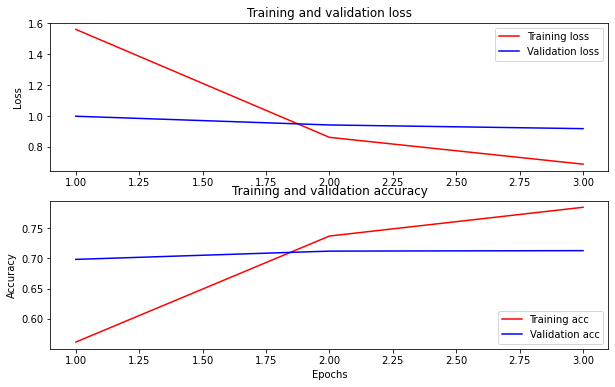

In [12]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [13]:
# export for later use

export_path = '/content/gdrive/My Drive/literature_update/Data/BiomchBERT/'
classifier_model.save(export_path)
reloaded_model = tf.saved_model.load(export_path)


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/literature_update/Data/BiomchBERT/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/literature_update/Data/BiomchBERT/assets


In [14]:

# #test loaded model on a handful of strings
# def print_my_examples(inputs, results, probability):
#   result_for_printing = \
#     [f'input: {inputs[i]:<30} : \nlabel: {results[i]} probability: {np.round(np.max(probability[i]),2)}'
#                          for i in range(len(inputs))]
#   print(*result_for_printing, sep='\n')
#   # print('probability: ', np.max(probability))
#   print()

# examples = [
#     "Calcaneus range of motion underestimated by markers on running shoe heel.The measurement of rearfoot kinematics by placing reflective markers on the shoe heel assumes its motion is identical to the foot's motion. Studies have compared foot and shoe kinematics during running but with conflicting results. The primary purpose of this study was to compare shoe and calcaneus three-dimensional range of motion during running. A secondary purpose was to determine the effect of a less rigid heel counter on tibia motion. Three-dimensional coordinate data were collected on 14 subjects (M/F: 9/5) who ran on an instrumented treadmill at 3.35 m/s under four conditions: modified/intact neutral shoes, and modified/intact support shoes. Shoes were modified by placing holes through the heel to allow for shoe heel and calcaneus coordinate data to be collected simultaneously via reflective markers on the shoe and on the skin of the heel within the shoe. Calcaneus, shoe heel, and tibia ROM were calculated from 0 to 50% stance phase and compared across shoe conditions.",
#     'A review of on-field investigations into the biomechanics of concussion in football and translation to head injury mitigation strategies'
# ]

# # probablity of each class
# reloaded_probability = reloaded_model(tf.constant(examples))
# # which class has highest probablity
# reloaded_results = tf.argmax(reloaded_probability, axis=1)
# # convert class number to string using original label encoder (le)
# print('Results from the saved model:')
# print_my_examples(examples, le.inverse_transform(reloaded_results), reloaded_probability)


In [14]:
print(len(X_test))

2563


In [15]:
## Network inference ----
print(len(X_test))
# #cant predict values for 3000+ titles/abstracts at once into memory so let's do it in two batches:
pred_1 = reloaded_model(X_test.iloc[0:1700], training=False)
pred_2 = reloaded_model(X_test.iloc[1700:], training=False)
pred = tf.concat([pred_1, pred_2], axis=0)
pred = tf.argmax(pred, axis=1)


2563


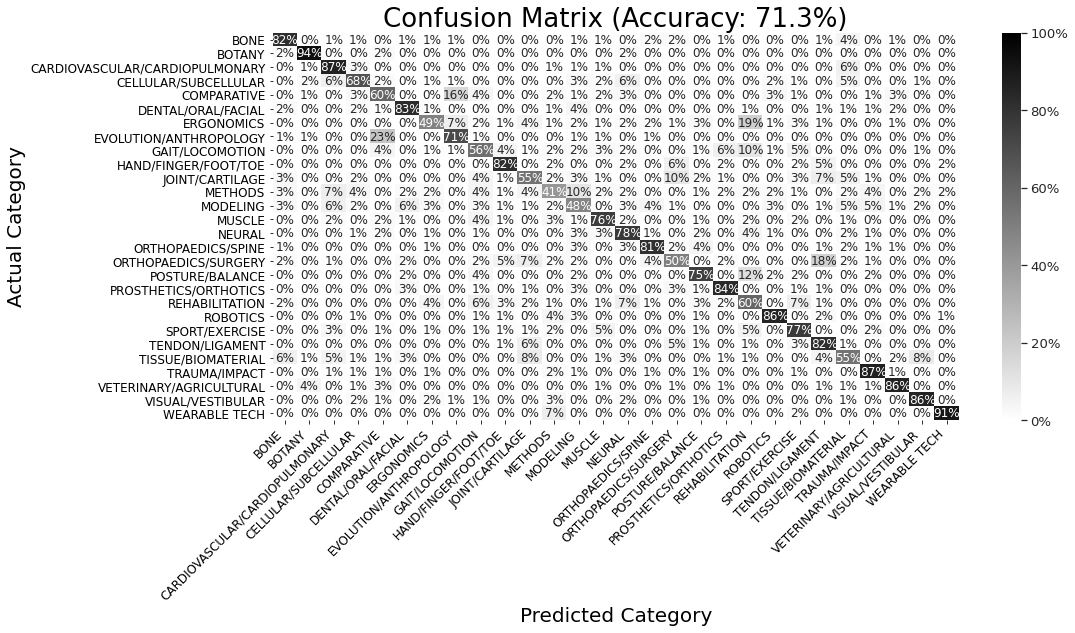

In [16]:
## Plot confusion matrix for validation data

plt.rc('xtick',labelsize = 20)
plt.rc('ytick',labelsize = 20)
conf_mat = confusion_matrix(y_test, pred)
conf_mat_rowsum = np.array([sum(row) for row in conf_mat])
conf_mat_perc = np.divide(conf_mat,conf_mat_rowsum[:,None])
fig, ax = plt.subplots(figsize=(16,9))
sns.set(font_scale=1.2) #font size multiplier
cm = sns.heatmap(conf_mat_perc, annot=True, fmt='.0%', cmap = 'binary', annot_kws={"size": 12},
                 xticklabels=le.inverse_transform(range(len(class_names))), 
                 yticklabels=le.inverse_transform(range(len(class_names))),
                 vmin=0, vmax=1)
cbar = cm.collections[0].colorbar
cbar.set_ticks([0, .2, .4, .6, .8, 1.])
cbar.set_ticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])

plt.ylabel('Actual Category',fontsize = 20)
plt.xlabel('Predicted Category',fontsize = 20)
plt.yticks(size = 12)
plt.xticks(size = 12, rotation=45,ha='right')
plt.title('Confusion Matrix (Accuracy: '+str(round(sum(np.diagonal(conf_mat))/X_test.shape[0]*100,1)) + '%)', fontsize = 26)
plt.yticks( rotation='horizontal')
fig.tight_layout(pad = 1)
plt.show()
fig.savefig('/content/gdrive/My Drive/literature_update/Plots/BiomchBERT_confusion_matrix.png')
